**Step 1: Import Fast.ai**

In [3]:
!pip install -Uqq fastai duckduckgo_search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.2/232.2 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 22.7 MB/s eta 0:00:00


**Step 2: Download images of birds and non-birds**

In [4]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    with DDGS() as ddgs:
        # generator which yields dicts with:
        # {'title','image','thumbnail','url','height','width','source'}
        search_results = ddgs.images(keywords=term)
        # grap number of max_images urls
        image_urls = [next(search_results).get("image") for _ in range(max_images)]
        # convert to L (functionally extended list class from fastai)
        return L(image_urls)

**Step 3: Search for Images of Birds and Download the Image**



Searching for 'bird photos'


<ipython-input-4-74f6028c57d0>:6: UserWarning: DDGS running in an async loop. This may cause errors. Use AsyncDDGS instead.
  with DDGS() as ddgs:


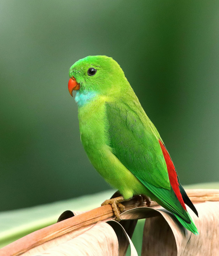

In [5]:
urls = search_images('bird photos', max_images=30)
urls[0]

#Download the image
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

**Step 4: Search for and download images of cats**

In [6]:
#Search for images of cats
download_url(search_images('cats', max_images=1)[0], 'cat.jpg', show_progress=False)
Image.open('cat.jpg').to_thumb(256,256)

#Download the image
searches = 'cat','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'cats'


<ipython-input-4-74f6028c57d0>:6: UserWarning: DDGS running in an async loop. This may cause errors. Use AsyncDDGS instead.
  with DDGS() as ddgs:


Searching for 'cat photo'
Searching for 'cat sun photo'
Searching for 'cat shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


**Step 5: Delete images that may not import correctly**

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

3

**Step 6: Train Model**

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return nested_attr(torch, 'backends.mps.is_built', False)()
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 60.4MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.662364,0.273436,0.096774,00:16


epoch,train_loss,valid_loss,error_rate,time
0,0.417037,0.154290,0.129032,00:21
1,0.267918,0.086829,0.032258,00:21
2,0.210138,0.094204,0.064516,00:21


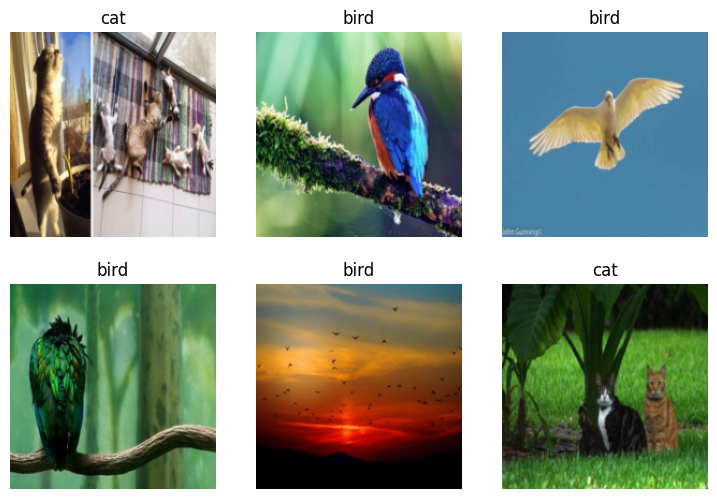

In [8]:
#First, bring in data loaders,  which is an object that contains a training set (the images used to create a model)
#and a validation set (the images used to check the accuracy of a model -- not used during training)
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

#Now, train model
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

**Step 7: Test Model**

In [9]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 0.9998


**Step 7a: Confusion Matrix**

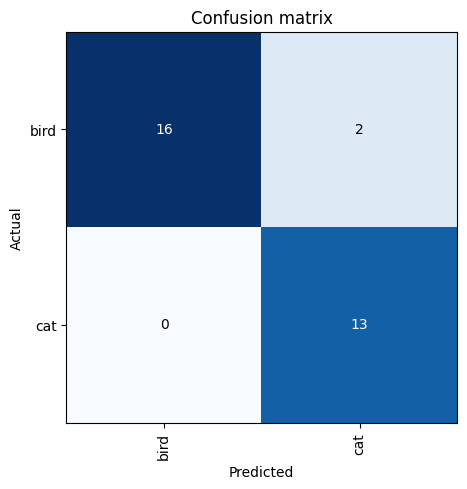

In [10]:
from fastai.interpret import ClassificationInterpretation
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

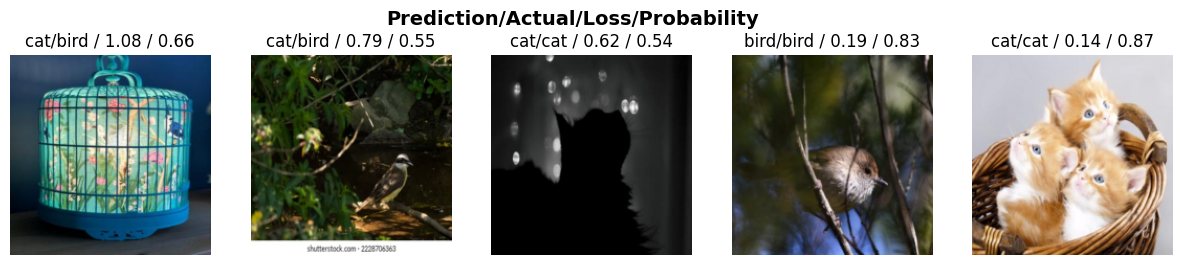

In [11]:
#sort images by loss-->loss is a number that is higher if the model is
#incorrect (especially if it's also confident of its incorrect answer), or if it's correct,
#but not confident of its correct answer
interp.plot_top_losses(5, nrows=1)